In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = l2_regularizer))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    '''
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Checkpoint 100, Accuracy: 0.9012345679012346, Loss: 0.4341686390064381
Checkpoint 200, Accuracy: 0.8950617283950617, Loss: 0.4189390606350369
Checkpoint 300, Accuracy: 0.9074074074074074, Loss: 0.4101628197564019
Checkpoint 400, Accuracy: 0.9259259259259259, Loss: 0.3886005613538954
Checkpoint 500, Accuracy: 0.9259259259259259, Loss: 0.37589550018310547


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [0.2573568  0.72393996 0.01870319]
[1. 0. 0.] <-> [0.8394965  0.06132944 0.09917406]
[0. 0. 1.] <-> [0.8018076  0.03583184 0.16236058]
[1. 0. 0.] <-> [0.83145076 0.03084074 0.13770853]
[0. 0. 1.] <-> [0.8216062  0.03386052 0.14453325]
[1. 0. 0.] <-> [0.84936446 0.02649421 0.12414127]
[0. 1. 0.] <-> [0.24832165 0.72999984 0.02167851]
[1. 0. 0.] <-> [0.7528255  0.05397446 0.19320013]
[1. 0. 0.] <-> [0.79083437 0.1321742  0.07699144]
[1. 0. 0.] <-> [0.7856269  0.06532314 0.14904995]
[1. 0. 0.] <-> [0.7498481  0.12120913 0.12894276]
[1. 0. 0.] <-> [0.7297352  0.07214915 0.19811568]
[1. 0. 0.] <-> [0.7549756  0.18446492 0.06055942]
[1. 0. 0.] <-> [0.79387635 0.10535145 0.1007722 ]
[1. 0. 0.] <-> [0.8703481  0.03218265 0.09746925]
[1. 0. 0.] <-> [0.793105   0.05371514 0.15317988]
[1. 0. 0.] <-> [0.7195616  0.11769008 0.16274835]
[1. 0. 0.] <-> [0.74780035 0.14563596 0.10656375]
[1. 0. 0.] <-> [0.7757404  0.06885196 0.15540773]
[1. 0. 0.] <-> [0.8294713  0.07256395 0.09796479]


In [12]:
# Testing Performance

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


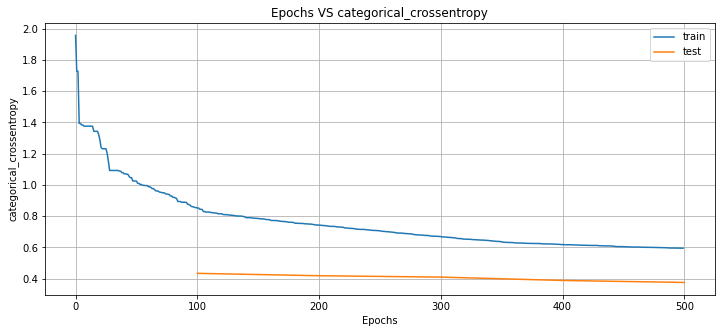

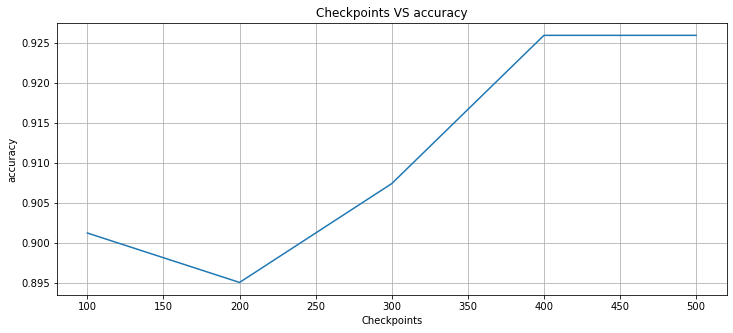

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9012345679012346, 'mean_square_error': 0.2495644888973059, 'categorical_crossentropy': 0.4341686390064381, 'precision': 0.8518518518518519, 'recall': 0.8518518518518519, 'f1': 0.8518518518518519, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 1}, 1: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 9}, 2: {'tp_hit': 9, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.8950617283950617, 'mean_square_error': 0.22991891145111282, 'categorical_crossentropy': 0.4189390606350369, 'precision': 0.8425925925925926, 'recall': 0.8425925925925926, 'f1': 0.8425925925925926, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 16, 'tn_hit': 16, 'fn_hit': 1}, 1: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 9}, 2: {'tp_hit': 8, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 7}}, 'checkpoint': 200} 


{'accuracy': 0.9074074074074074, 'mean_square_error': 0.2203264422951289, 'categorical_crossentropy': 0.4101628197564019, 'precision': 

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.38056543 -0.94603586 -0.38702193  0.15200272  0.51619756]
 bias: -0.13110199570655823

Neuron 1: weights:
[ 0.40802163 -0.1611389   0.63429874  0.81489754  0.8018537 ]
 bias: -0.566240131855011

Neuron 2: weights:
[-4.8596910e-01  1.0149077e+00  4.7174495e-01 -8.0088666e-04
 -4.2063728e-01]
 bias: -0.2315777987241745

Neuron 3: weights:
[ 0.160744  -0.729928  -0.7639188 -0.5359947 -0.4726509]
 bias: 0.4974546432495117

$
Layer 2
Neuron 0: weights:
[-0.01435486 -1.2246025  -0.270106    1.1613767 ]
 bias: 0.7737687230110168

Neuron 1: weights:
[-1.5272615   0.13700972  1.5773298  -1.127061  ]
 bias: -0.19767233729362488

Neuron 2: weights:
[ 1.1524177   1.1712327  -1.6380124  -0.47218698]
 bias: -0.8282284140586853

$

